<a href="https://colab.research.google.com/github/bharathts1507/TSAI-Assignments-EVA4/blob/master/Session_12_Worksheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount the google drive
from google.colab import drive
drive.mount( '/content/drive', force_remount=True )


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import cv2
import numpy as np
from datatransforms import AlbumentationTransforms
import albumentations as A
from torchvision import transforms

import json
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import patches



In [0]:
import sys
# sys.path.append("/content/drive/My Drive/TSAI_EVA4/Session 12/")
sys.path.append("/content/drive/My Drive/TSAI_EVA4/Library/")



In [4]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 24.35 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [5]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"


  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-0e_uwauc
All libraries are successfully installed!


In [0]:
channel_means = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations

train_transforms = AlbumentationTransforms([
                                      #A.PadIfNeeded(min_height=80, min_width=80, border_mode=cv2.BORDER_CONSTANT, value=np.array(channel_means)*255),
                                      #A.RandomCrop(64,64, always_apply=True),
                                      A.Rotate((-30.0, 30.0)),
                                      A.HorizontalFlip(),
                                      #A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.ToGray(),
                                      A.RandomBrightnessContrast(),
                                      A.RandomResizedCrop(64, 64, scale=(0.75, 1.0), ratio=(0.9, 1.1), p=0.8),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, fill_value=0, p=1.0)
                                      #A.Cutout(num_holes=6, max_h_size=16, max_w_size=16) # fillvalue is 0 after normalizing as mean is 0
                                    ])

fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [0]:
from datasets import tinyimagenet

dataset, class_names = tinyimagenet.alldata('IMagenet/tiny-imagenet-200/')
trainlen = int(len(dataset)*0.7)
train = tinyimagenet.TinyImagenetDataset(dataset[:trainlen], transform=train_transforms)
test = tinyimagenet.TinyImagenetDataset(dataset[trainlen:], transform=test_transforms)

In [0]:
import dataloaders
batch_size=256

dataloader = dataloaders.DataLoader(batch_size=batch_size, shuffle=True)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [9]:

def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

num_classes = len(class_names)

torch.Size([256, 3, 64, 64])
torch.Size([256])


In [10]:
from models.resnet import ResNet18

model = ResNet18(name="s12-resnet-sgd3", num_classes=len(class_names))
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


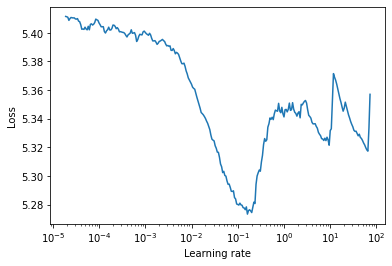

In [12]:
# LR finder
import torch.nn as nn
import torch.nn.functional as F
from LRFinder import LRFinder
import torch.optim as optim
L1lambda = 0
L2lambda = 1e-4
criterion = F.nll_loss
optimizer = optim.SGD(model.parameters(), lr=1e-5) #optim.Adam(model.parameters(), lr=1e-5, weight_decay=L2lambda) # 
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=len(train_loader))
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


In [13]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
print(lr[loss.index(min(loss))])
max_lr = lr[loss.index(min(loss))]


0.16192068244593724


In [14]:
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
EPOCHS = 50
max_lr=2
optimizer = optim.SGD(model.parameters(), lr=max_lr/10, momentum=0.9, nesterov=True, weight_decay=L2lambda)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=int(len(train_loader))+1, epochs=EPOCHS,  pct_start=0.2, div_factor=10, final_div_factor=100 )

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive/TSAI_EVA4/Session 12/", scheduler, True,L1lambda)

KeyboardInterrupt: ignored

In [0]:
#Part 2:  Create clusters of images bounding box 

In [0]:
import json
with open("/content/drive/My Drive/TSAI_EVA4/Library/via_export_coco2.json","r") as infile:
    df2 = json.load(infile)

x,y,w,h,img,img_width,img_height,class_type=[],[],[],[],[],[],[],[]
for i in range(50):
    
    img.append( df2['images'][i]['file_name'])
    x.append(df2['annotations'][i]['bbox'][0])
    y.append(df2['annotations'][i]['bbox'][1])
    
    w.append(df2['annotations'][i]['bbox'][2])
    h.append(df2['annotations'][i]['bbox'][3])
    
    img_width.append(df2['images'][i]['width'])
    img_height.append(df2['images'][i]['height'])
    class_type.append('dog')
  

data = pd.DataFrame(zip(img,x,y,w,h,img_width,img_height,class_type), columns =['img','x','y','w','h','img_width','img_height','class_type'])


In [0]:
data['x']= data['x']/data['img_width']
data['y']= data['y']/data['img_height']

data['w']= data['w']/data['img_width']
data['h']= data['h']/data['img_height']

X = data[['w','h']].reset_index()
del X['index']

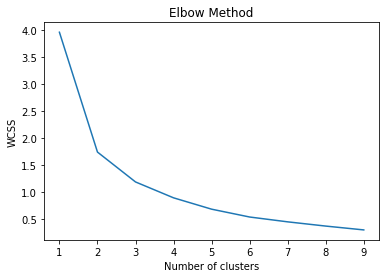

In [25]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

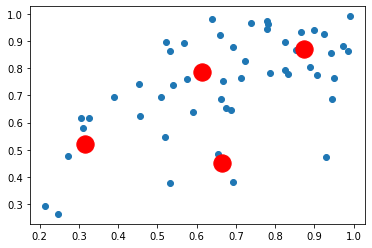

In [26]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X['w'], X['h'])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [27]:
kmeans.cluster_centers_

array([[0.8735    , 0.86921071],
       [0.31475   , 0.52075014],
       [0.61258824, 0.78446595],
       [0.6652    , 0.45275562]])

In [40]:
print(kmeans.cluster_centers_[0][0],kmeans.cluster_centers_[0][1],
kmeans.cluster_centers_[1][0],kmeans.cluster_centers_[1][1])

0.8734999999999999 0.8692107055722209 0.3147499999999999 0.5207501392525922


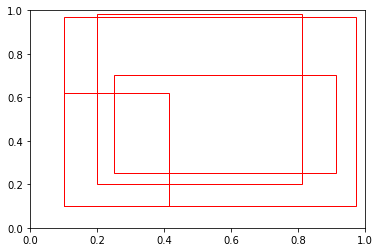

In [42]:

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
# ax.plot(image)

# Create a Rectangle patch
rect1 =patches.Rectangle((0.1,0.1), kmeans.cluster_centers_[0][0], kmeans.cluster_centers_[0][1], linewidth=1,edgecolor='r',facecolor='none')
rect2 =patches.Rectangle((0.1,0.1), kmeans.cluster_centers_[1][0], kmeans.cluster_centers_[1][1], linewidth=1,edgecolor='r',facecolor='none')
rect3 =patches.Rectangle((0.2,0.2), kmeans.cluster_centers_[2][0], kmeans.cluster_centers_[2][1], linewidth=1,edgecolor='r',facecolor='none')
rect4 =patches.Rectangle((0.25,0.25), kmeans.cluster_centers_[3][0], kmeans.cluster_centers_[3][1], linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)


plt.show()